# CNN Model using PyTorch for Abdominal Trauma Detection in CT scan

> Detect and classify traumatic abdominal injuries

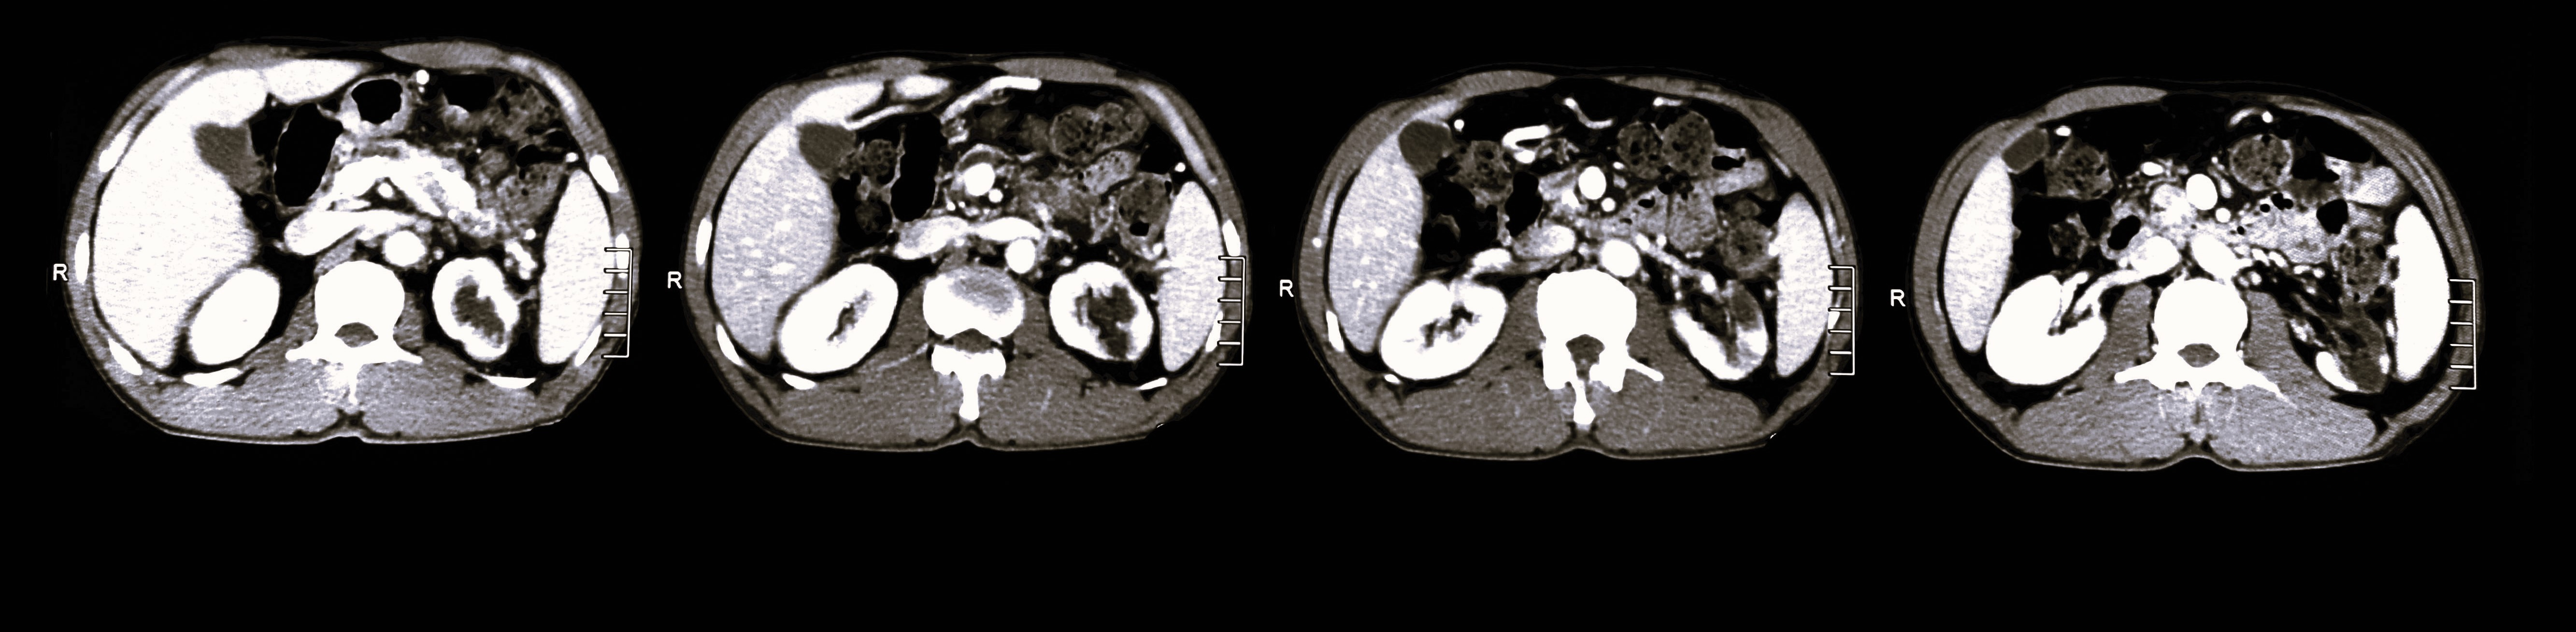

In [18]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os 

from tqdm import tqdm

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Version Check

In [2]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('torch:',torch.__version__)

np: 1.26.0
pd: 2.1.3
sklearn: 1.3.2
torch: 2.1.0


## 1. Data Loading and Preprocessing
First, we'll define the code for loading and preprocessing the data. This involves normalizing the tensors and splitting the dataset into training and validation sets.

### Dataset Preparation with Balancing

In [3]:
#define my path in hard drive
# Windows
data_dir = "S:/Capston/data2"
# My 3D tensor files directory
SAVE_FOLDER = "S:/Capston/data4"

In [4]:
class CFG:
    model_name = 'PyTorch_CNN'

    # size of the image
    img_size = [128, 128]

    # seed for data-split, layer init, augs
    seed = 42

    # batch_size, epochs and learning_rate 
    batch_size = 8  
    epochs = 10    
    learning_rate = 0.001 
    
    # target column
    target_col  = ['bowel_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high'] # not using 'bowel_healthy', 'extravasation_healthy', 'extravasation_injury' & 'any_injury'

In [5]:
# Read CSV and making dataframe
df = pd.read_csv(os.path.join(data_dir,'patients_meta_plus_path.csv'))
# sanity check
df.shape

(3147, 16)

In [6]:
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,paths
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,S:\Capston\data4\10004.pt
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0,S:\Capston\data4\10005.pt
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0,S:\Capston\data4\10007.pt
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0,S:\Capston\data4\10026.pt
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1,S:\Capston\data4\10051.pt


In [7]:
df.columns

Index(['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury', 'paths'],
      dtype='object')

In [8]:
df = df.drop(columns=['bowel_healthy', 'extravasation_healthy',
       'extravasation_injury','any_injury'])

In [9]:
# Splitting the dataset
remain_df, test_df = train_test_split(df, test_size=0.2, random_state=CFG.seed)  # 20% data for testing
train_df, val_df = train_test_split(remain_df, test_size=0.25, random_state=CFG.seed)  # 60% training, 20% validation

# Balancing the training dataset
class_counts = train_df[['bowel_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high']].sum().values
num_samples = len(train_df)
weights = 1. / class_counts
samples_weights = weights[train_df[['bowel_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high']].values.argmax(axis=1)]
sampler = WeightedRandomSampler(samples_weights, num_samples)


In [10]:
class CTScanDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame containing the file paths and labels.
            root_dir (string): Directory with all the tensor files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, -1])
        # ... load the image ...
        image = torch.load(img_name)
        # Add a channel dimension
        image = image.unsqueeze(0)  # This adds a channel dimension
        labels = self.dataframe.iloc[idx, 1:-1].values
        labels = torch.from_numpy(labels.astype('float')).float()

        if self.transform:
            image = self.transform(image)

        return image, labels

# Dataset and DataLoader
train_dataset = CTScanDataset(train_df, SAVE_FOLDER)
val_dataset = CTScanDataset(val_df, SAVE_FOLDER)
test_dataset = CTScanDataset(test_df, SAVE_FOLDER)

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)


## 2. CNN Model Architecture
Next, we'll define a simple 3D CNN model architecture.

In [11]:

class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()

        # Define the first convolutional layer
        # It takes an input with 1 channel (e.g., grayscale image) and produces 16 feature maps
        # Kernel size is set to 3
        self.conv1 = nn.Conv3d(1, 16, 3)

        # Define a max pooling layer
        # It reduces the spatial dimensions (width, height, depth) by half
        self.pool = nn.MaxPool3d(2, 2)

        # Define the second convolutional layer
        # It takes the 16 feature maps as input and produces 32 feature maps
        # Kernel size is again set to 3
        self.conv2 = nn.Conv3d(16, 32, 3)

        # Define the first fully connected (linear) layer
        # The number 32 * 30 * 30 * 30 represents the total number of features coming from the previous layer
        # It is calculated based on the output size of the last pooling layer
        # The output of this layer is 120 features
        self.fc1 = nn.Linear(32 * 30 * 30 * 30, 120)

        # Define the second fully connected layer
        # It takes the 120 features as input and reduces them to 84
        self.fc2 = nn.Linear(120, 84)

        # Define the third fully connected layer
        # It takes the 84 features as input and produces 10 output features
        # This can be used for a classification task with 10 classes
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation function and pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply the second convolutional layer followed by ReLU activation function and pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output from the convolutional layers to feed into the fully connected layers
        x = x.view(x.size(0), -1)

        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))

        # Apply the second fully connected layer with ReLU activation
        x = F.relu(self.fc2(x))

        # Apply the third fully connected layer
        # No activation function is used here, assuming the use of a softmax activation in the loss function for classification
        x = self.fc3(x)

        return x

# Create an instance of the Simple3DCNN model
model = Simple3DCNN()

# Print the model's structure
print(model)

Simple3DCNN(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (fc1): Linear(in_features=864000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 3. Training the Model
Finally, we'll set up a basic training loop.

In [12]:
# Define the criterion and optimizer
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(model.parameters(), lr=CFG.learning_rate, momentum=0.9)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    label_correct = torch.zeros(10)  # Assuming 10 labels
    label_total = torch.zeros(10)
    predicted = (outputs > 0.5).float()
    for i in range(10):  # Loop over each label
        label_total[i] += len(labels[:, i])  # Total instances of each label
        label_correct[i] += (predicted[:, i] == labels[:, i]).sum()  # Correct predictions for each label
    label_accuracy = 100 * label_correct / label_total
    acc = sum(label_accuracy) / len(label_accuracy)
    return acc

# Arrays to track training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with accuracy tracking
num_epochs = CFG.epochs 
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_acc = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += calculate_accuracy(outputs, labels)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            total_val_loss += loss.item()
            total_val_acc += calculate_accuracy(outputs, labels)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

print('Finished Training')

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 236/236 [26:00<00:00,  6.61s/it]


Epoch 1, Train Loss: 0.3375, Train Acc: 89.9561, Val Loss: 0.2874, Val Acc: 92.9800


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 236/236 [26:46<00:00,  6.81s/it]


Epoch 2, Train Loss: 0.0585, Train Acc: 98.5964, Val Loss: 0.2719, Val Acc: 90.7859


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 236/236 [27:23<00:00,  6.96s/it]


Epoch 3, Train Loss: 0.0393, Train Acc: 99.0451, Val Loss: 0.2657, Val Acc: 92.5316


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 236/236 [29:06<00:00,  7.40s/it]


Epoch 4, Train Loss: 0.0261, Train Acc: 99.3485, Val Loss: 0.3307, Val Acc: 90.4694


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 236/236 [28:24<00:00,  7.22s/it]


Epoch 5, Train Loss: 0.0208, Train Acc: 99.4492, Val Loss: 0.3813, Val Acc: 94.2774


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 236/236 [28:25<00:00,  7.23s/it]


Epoch 6, Train Loss: 0.0159, Train Acc: 99.6239, Val Loss: 0.3189, Val Acc: 93.4599


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 236/236 [28:11<00:00,  7.17s/it]


Epoch 7, Train Loss: 0.0168, Train Acc: 99.5922, Val Loss: 0.3300, Val Acc: 94.1192


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 236/236 [28:36<00:00,  7.27s/it]


Epoch 8, Train Loss: 0.0188, Train Acc: 99.5922, Val Loss: 0.3478, Val Acc: 94.1192


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 236/236 [30:05<00:00,  7.65s/it]


Epoch 9, Train Loss: 0.0129, Train Acc: 99.6769, Val Loss: 0.3580, Val Acc: 93.8977


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 236/236 [41:02<00:00, 10.43s/it]


Epoch 10, Train Loss: 0.0073, Train Acc: 99.8411, Val Loss: 0.3613, Val Acc: 93.5179
Finished Training


## 4.Evaluate the Model

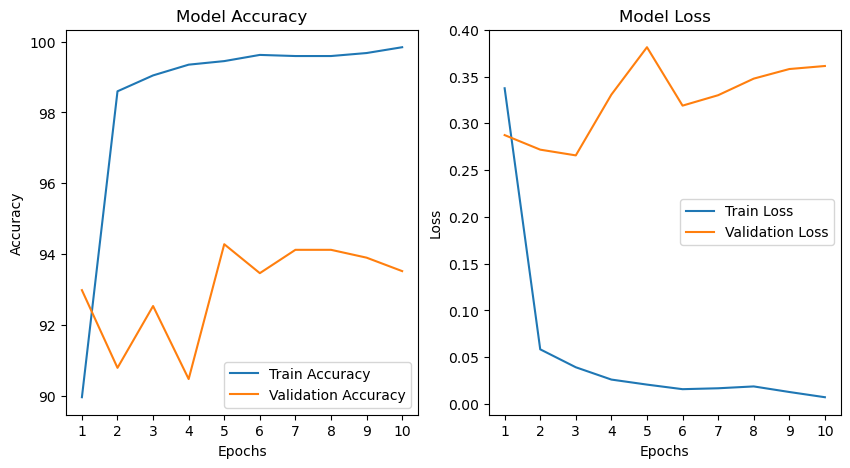

In [13]:
# Creating a figure and two subplots (axes) side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Flatten the array of axes to easily index each subplot
ax = ax.ravel()
num_epochs = len(train_accuracies)

# Plotting training and validation accuracies on the first subplot
ax[0].plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
ax[0].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].set_xticks(range(1, num_epochs + 1))  # Set x-ticks to show each epoch

# Plotting training and validation losses on the second subplot
ax[1].plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
ax[1].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].set_xticks(range(1, num_epochs + 1))  # Set x-ticks to show each epoch                             # Display legend for the second subplot

# Display and save the plot
plt.savefig( "S:/Capston/data/model/" + CFG.model_name + "_" + str(CFG.epochs) + "epoch_" + str(CFG.batch_size) + "batch.png", dpi=600)
plt.savefig( "S:/Capston/data/model/" + CFG.model_name + "_" + str(CFG.epochs) + "epoch_" + str(CFG.batch_size) + "batch_trans.png", dpi=600, transparent=True)
plt.show()

In [14]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize counters
label_correct = torch.zeros(10)  # Assuming 10 labels
label_total = torch.zeros(10)

# No gradient is needed for evaluation
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)

        # Convert outputs to predictions: apply a threshold for multi-label classification
        predicted = (outputs > 0.5).float()
        for i in range(10):  # Loop over each label
            label_total[i] += len(labels[:, i])  # Total instances of each label
            label_correct[i] += (predicted[:, i] == labels[:, i]).sum()  # Correct predictions for each label

# Calculate the accuracy for each label
label_accuracy = 100 * label_correct / label_total

# Print and saving accuracy for each label
file1 = open("S:/Capston/data/model/" + CFG.model_name + "_" + str(CFG.epochs) + "epoch_" + str(CFG.batch_size) + "batch.txt","w")
for i in range(10):
    L = [f'Accuracy for {CFG.target_col[i]}: {label_accuracy[i]:.2f}% \n']
    file1.writelines(L)
    print(L[0], end='')
file1.close()

Accuracy for bowel_injury: 98.57% 
Accuracy for kidney_healthy: 92.86% 
Accuracy for kidney_low: 94.92% 
Accuracy for kidney_high: 98.10% 
Accuracy for liver_healthy: 85.71% 
Accuracy for liver_low: 90.79% 
Accuracy for liver_high: 97.94% 
Accuracy for spleen_healthy: 84.76% 
Accuracy for spleen_low: 92.70% 
Accuracy for spleen_high: 93.81% 


In [31]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize counters
TP = torch.zeros(10)  # True Positives
FP = torch.zeros(10)  # False Positives
TN = torch.zeros(10)  # True Negatives
FN = torch.zeros(10)  # False Negatives

# No gradient is needed for evaluation
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)

        # Convert outputs to predictions: apply a threshold for multi-label classification
        predicted = (outputs > 0.5).float()
        for i in range(10):  # Loop over each label
            TP[i] += ((predicted[:, i] == 1) & (labels[:, i] == 1)).sum()
            FP[i] += ((predicted[:, i] == 1) & (labels[:, i] == 0)).sum()
            TN[i] += ((predicted[:, i] == 0) & (labels[:, i] == 0)).sum()
            FN[i] += ((predicted[:, i] == 0) & (labels[:, i] == 1)).sum()

# Create and save confusion matrix for each label
for i in range(10):
    confusion_matrix = torch.tensor([[TP[i], FP[i]], [FN[i], TN[i]]])
    
    ax = sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues")
    ax.set_title(f'Confusion Matrix for Label {i}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Positive', 'Negative'])
    ax.yaxis.set_ticklabels(['Positive', 'Negative'])

    plt.savefig(f"S:/Capston/data/model/confusion_matrix_label_{i}.png")
    plt.clf()  # Clear the current figure for the next plot


<Figure size 640x480 with 0 Axes>

In [16]:
organ_counts = pd.DataFrame({
    'Organ': CFG.target_col,
    'count': label_accuracy
})


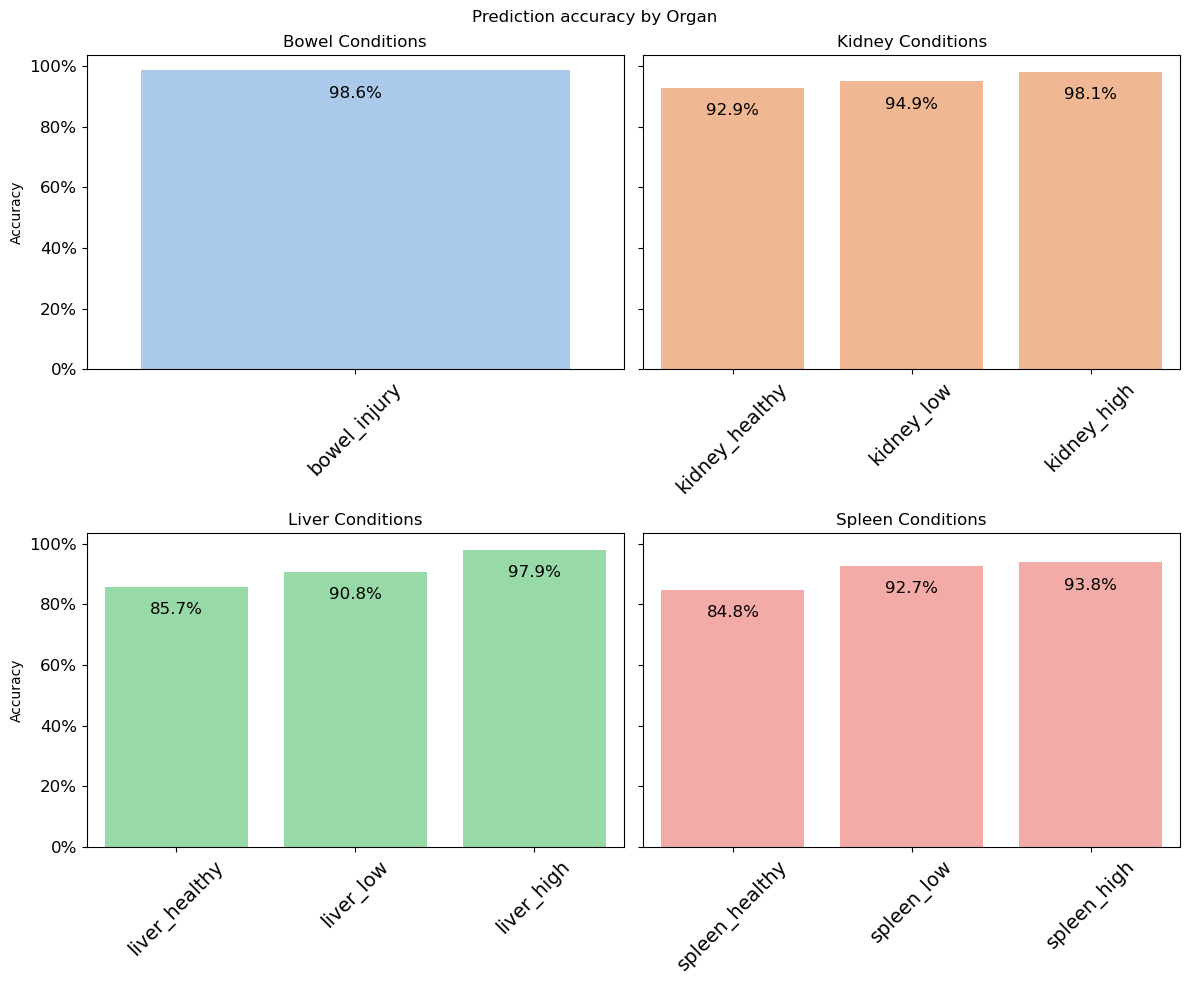

In [30]:
import matplotlib.ticker as mticker

organ_columns = ['bowel', 'kidney', 'liver', 'spleen']

# Create a pastel color palette
palette = sns.color_palette("pastel", len(organ_columns))

# Creating 2x2 subplots for each organ
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
fig.suptitle('Prediction accuracy by Organ')

for i, organ in enumerate(organ_columns):
    # Determine the subplot location
    ax = axes[i // 2, i % 2]

    # Filter the DataFrame for the current organ
    organ_data = organ_counts[organ_counts['Organ'].str.contains(organ)]
    
    # Create a bar plot for each organ with its unique color
    bars = sns.barplot(ax=ax, data=organ_data, x='Organ', y='count', color=palette[i])
    ax.set_title(f'{organ.capitalize()} Conditions')
    ax.set_xlabel('')
    ax.set_ylabel('Accuracy')

    # Annotate each bar with percentage
    for bar in bars.patches:
        ax.text(bar.get_x() + bar.get_width() / 2, 
                bar.get_height()-10, 
                f'{bar.get_height()/100:.1%}', 
                ha='center', 
                va='bottom',
               size=12)
    
    # Format y-axis to show percentage
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())

    ax.tick_params(axis='x', rotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig( "Prediction accuracy by Organ.png", dpi=600, transparent=True)
plt.show()

In [26]:
# saving my entire model
torch.save(model, "S:/Capston/data/model/" + CFG.model_name + "_" + str(CFG.epochs) + "epoch_" + str(CFG.batch_size) + "batch.pt")

<div id="container" style="position:relative;">
<div style="position:relative; float:right"><img style="height:100px""width: 100px" src ="Project logo.png" />
</div>
</div>